In [2]:
from qiskit import *
from tqdm import tqdm
from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 
backend = AerSimulator.from_backend(FakeParis())
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

In [138]:
#define unitary
def U(A,T,G):
    U = np.zeros((4,4), dtype=complex)
    
    U[0,0]=(-1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[0,3]=(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,1]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,2]=(-1+2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,1]=(-1-2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,2]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,0]=-(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,3]=(1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    return(U)

In [137]:
#unitarity check 
np.allclose(U(1,1,1)@U(1,1,1).conj().T , np.identity(4),atol=1e-10)

True

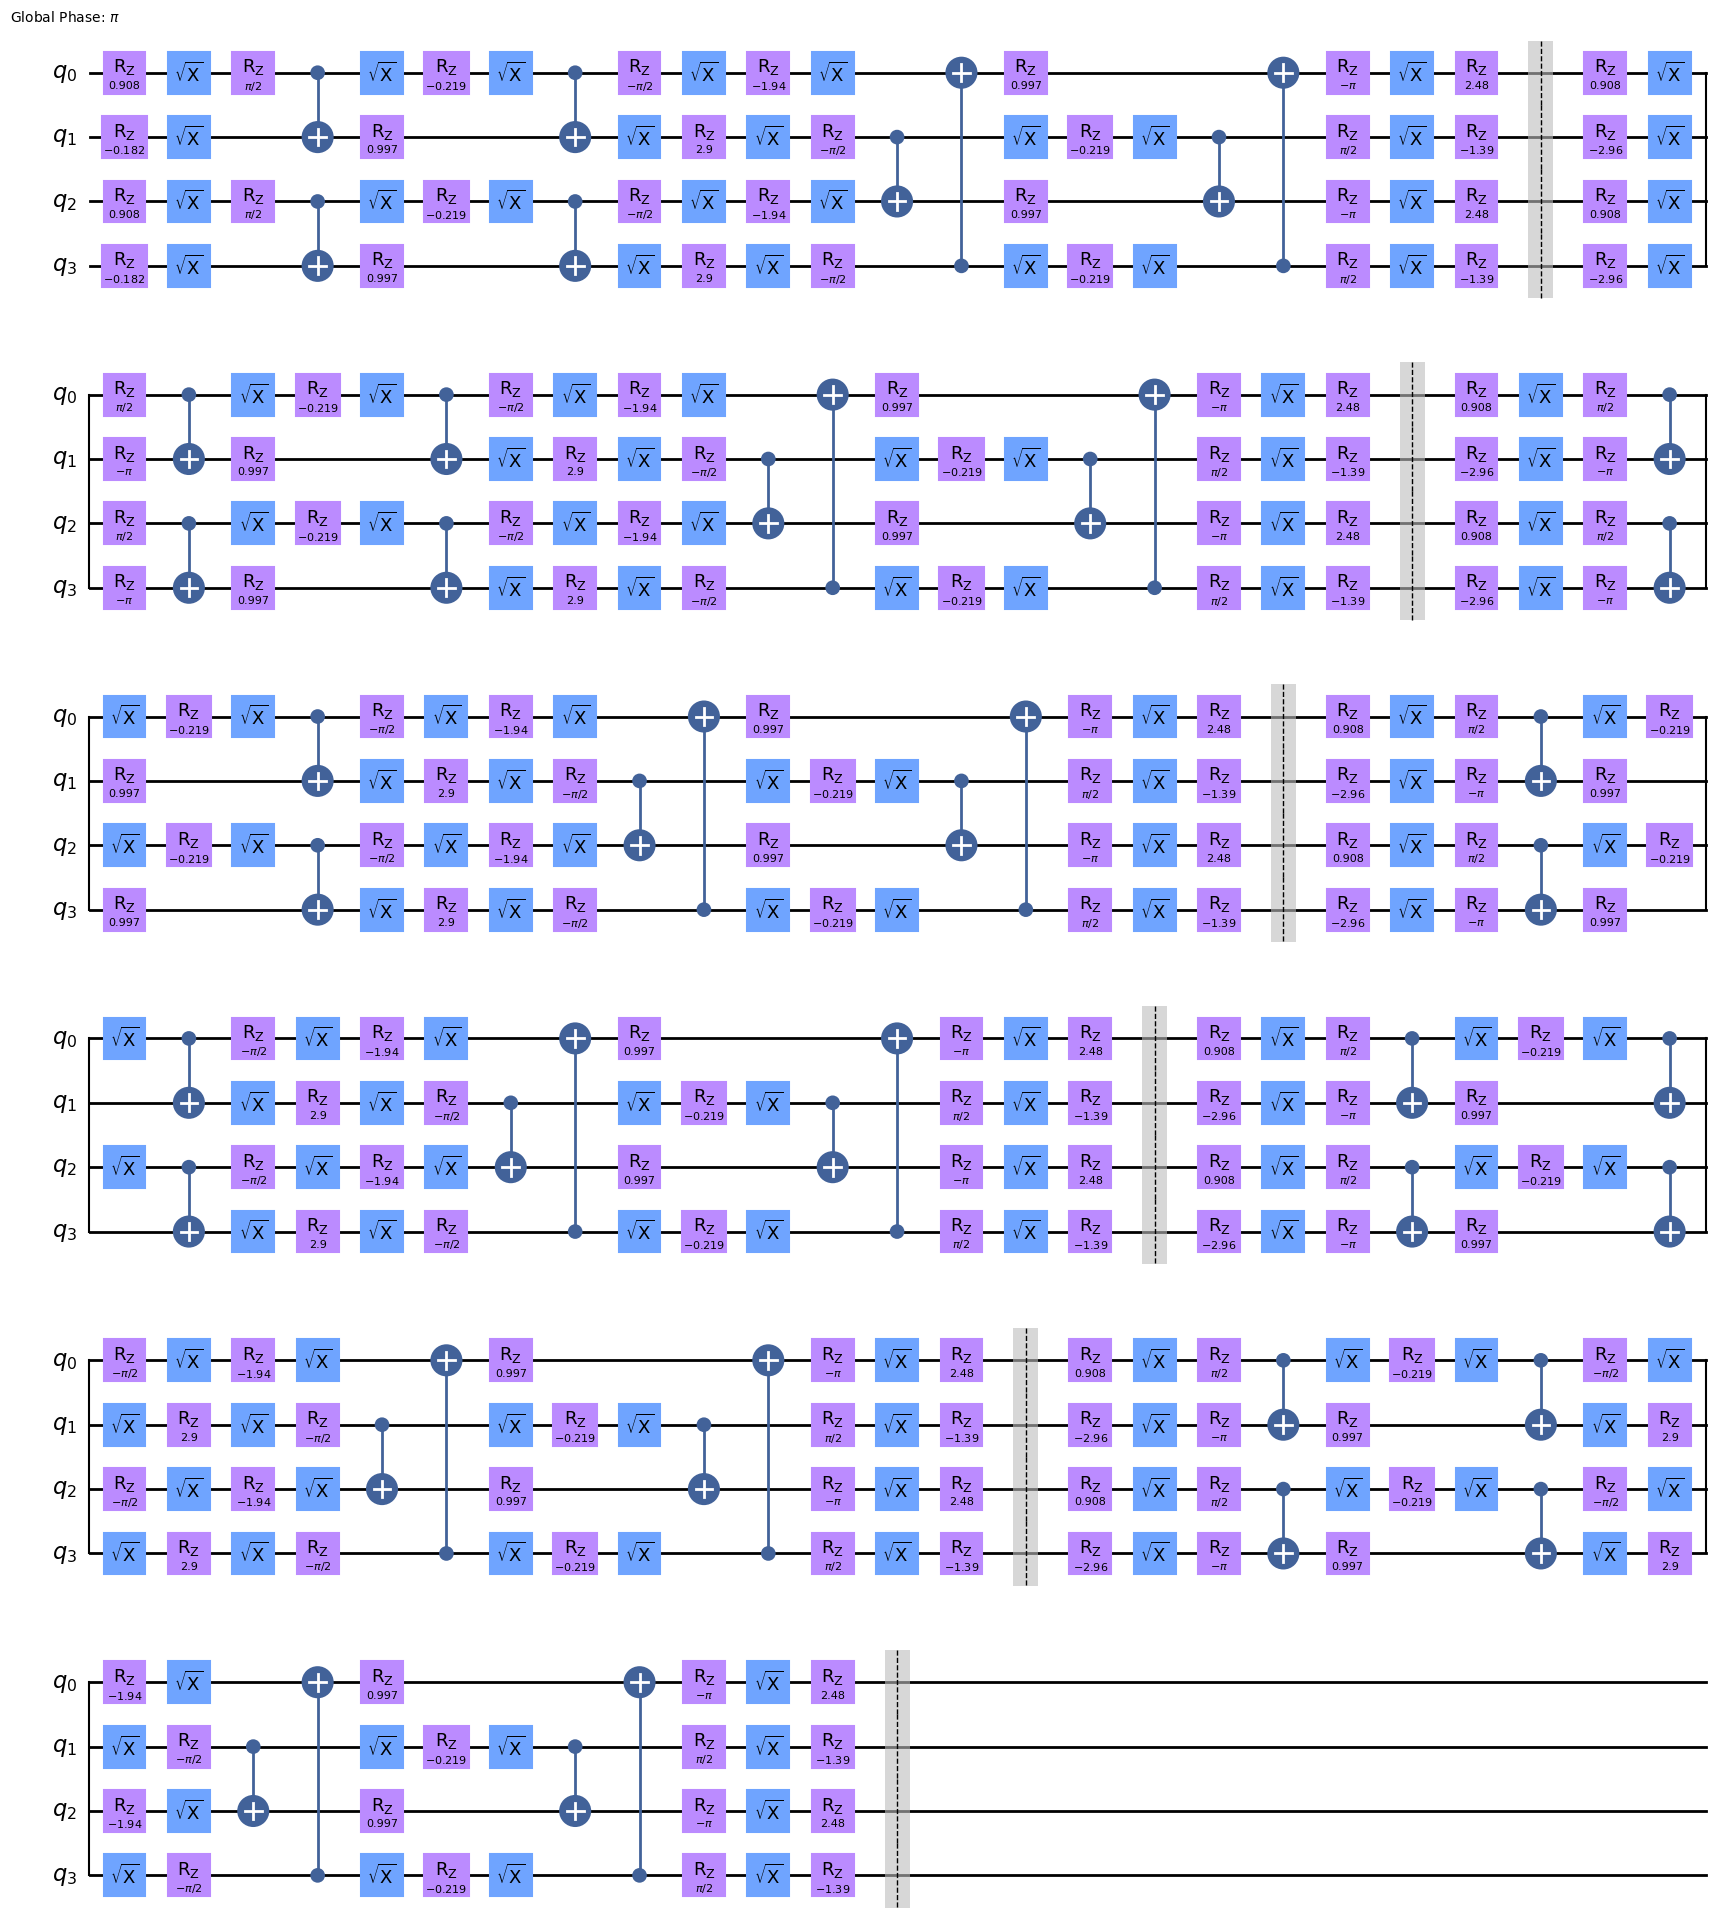

In [148]:

#build circuit    
qc = QuantumCircuit(4)

#v0=(1,0,0,0)#TODO:CHOOSE INITIAL STATE AND INIT
#init = U(1,1,1)@v0
#init = init.tolist()
QuantumCircuit.initialize(qc,'1010',[0,1,2,3])

#SPECIFY PARAMETERS
A=1;T=1;G=1;

matrix = U(A,T,G)
layers = 6
n=0
while n < layers:
    qc.unitary(matrix, [0,1])
    qc.unitary(matrix, [2,3])
    qc.unitary(matrix, [1,2])
    qc.unitary(matrix, [3,0])
    qc.barrier(range(4))
    n+=1

#PLOT

dispcolors = {'cx':('#426299', '#000000'),
              'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}


basis_gates=['cx', 'id', 'rz', 'x', 'sx']  # You can specify your native gates here

transpiled_circuit = transpile(qc, basis_gates=basis_gates)

#qc.measure(range(4))

transpiled_circuit.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')


AnalysisResult
- name: state
- value: DensityMatrix([[ 9.49373013e-01+0.00000000e+00j,
                 7.45528310e-03-1.31171644e-02j,
                 8.24936817e-03-5.07987928e-03j,
                 5.72527911e-03+2.41733822e-03j,
                 2.34477743e-03-6.46768606e-03j,
                -3.04536808e-03+6.85219723e-03j,
                 2.73423432e-03-5.16460068e-03j,
                -6.24456393e-03-8.85662473e-03j,
                 1.25068783e-02+3.00335131e-03j,
                 6.05144636e-03-3.44304074e-03j,
                -1.40490985e-03+2.11596642e-04j,
                -4.95712937e-03+5.44878568e-03j,
                -3.23527380e-03+3.00887018e-04j,
                 3.34463074e-03-3.21388669e-03j,
                -8.15763120e-03-8.11322923e-04j,
                -1.95103522e-03+4.51899338e-03j],
               [ 7.45528310e-03+1.31171644e-02j,
                 9.62273243e-03+1.98173875e-19j,
                -2.29479868e-03+1.41420568e-03j,
                 6.87897188e-0

/home/alberto/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


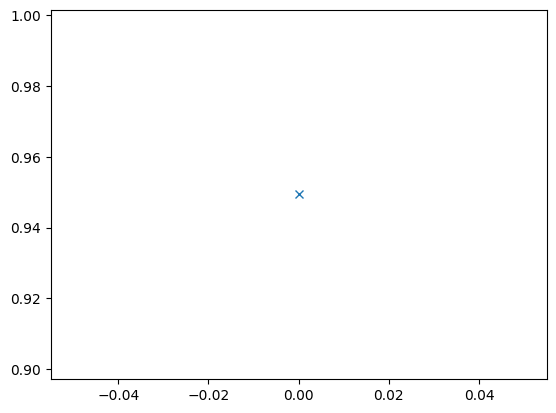

In [10]:
# QST Experiment
qstexp1 = StateTomography(qc)
qstdata1 = qstexp1.run(backend, shots=8000, seed_simulation=100).block_for_results()

# Print results
for result in qstdata1.analysis_results():
    print(result)

#fitted state extraction
final_state = qstdata1.analysis_results("state")
density=np.asarray(final_state.value)
print(density[0,0])
#A.append(density([0,0]))
plt.plot(density[0,0],'x')

In [ ]:
qc.decompose(reps=2).draw(output='mpl',style={'displaycolor':dispcolors}) #displays decomposition of circuit
backend = Aer.get_backend('statevector_simulator') # gets backend for simulation
job = backend.run(qc) #creates quantum program for exec
result = job.result()  #access result of sim
#status = job.status()  #check status of sim 
outputstate = result.get_statevector(qc, decimals=3)  #access statevector from results file
qobj = assemble(qc)#Assemble circuit into a Qobj that can be run

####
from qiskit.circuit import Parameter  #how to define parameter and bind it to range 
theta = Parameter('θ')
circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]  #this creates an array of circuits with different thetas
####VISUALIZATION######

from qiskit.visualization import plot_histogram
plot_histogram(counts)          #histogram of results' statistics

from qiskit.visualization import plot_state_city
plot_state_city(outputstate)   #nice visualization 3D

In [145]:
circ = QuantumCircuit(4)
matrix = U(1,1,1)
qc.unitary(matrix,[0,1])
qc.unitary(matrix,[2,3])



basis_gates=['cx', 'id', 'rz', 'x', 'sx']  # You can specify your native gates here

transpiled_circuit = transpile(circ, basis_gates=basis_gates)

